In [81]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import json
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold, GridSearchCV
import matplotlib.pyplot as plt



In [82]:
with open('features_config.json', 'r') as f:
    features_config = json.load(f)
features_config

{'numeric_columns': ['feature3',
  'feature4',
  'feature5',
  'feature6',
  'feature7',
  'feature8',
  'feature9',
  'feature10',
  'feature11',
  'feature12',
  'feature13',
  'feature14',
  'feature15',
  'feature16'],
 'category_columns': ['feature2', 'feature1'],
 'target_column': 'label',
 'ml_type': 'classification'}

In [83]:
train_data = pd.read_parquet('raw_train.parquet')

In [84]:
train_data.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,label,feature14,feature15,feature16
0,Site engineer,grocery_pos,8.60,48230,40.213439,-85.203756,47583,42.508293,-83.168004,65.596062,3,5,1,1,8.017865,1.028822,58.911132
1,Site engineer,gas_transport,316.84,48230,44.379391,-82.859721,47583,42.661838,-81.966510,64.728795,6,5,1,1,11.768568,1.106217,64.431017
2,Site engineer,grocery_pos,294.89,48230,42.950657,-84.935542,47583,42.580470,-82.408529,65.434606,3,5,1,1,7.996359,0.899881,57.545348
3,Site engineer,shopping_net,831.08,48230,39.372111,-84.893973,47583,41.948688,-83.919881,64.990422,23,6,1,1,8.767720,1.062966,62.681169
4,Site engineer,health_fitness,1063.84,48230,41.227499,-83.228392,47583,41.544743,-82.123365,65.316083,23,6,1,1,8.816222,0.722446,63.084486


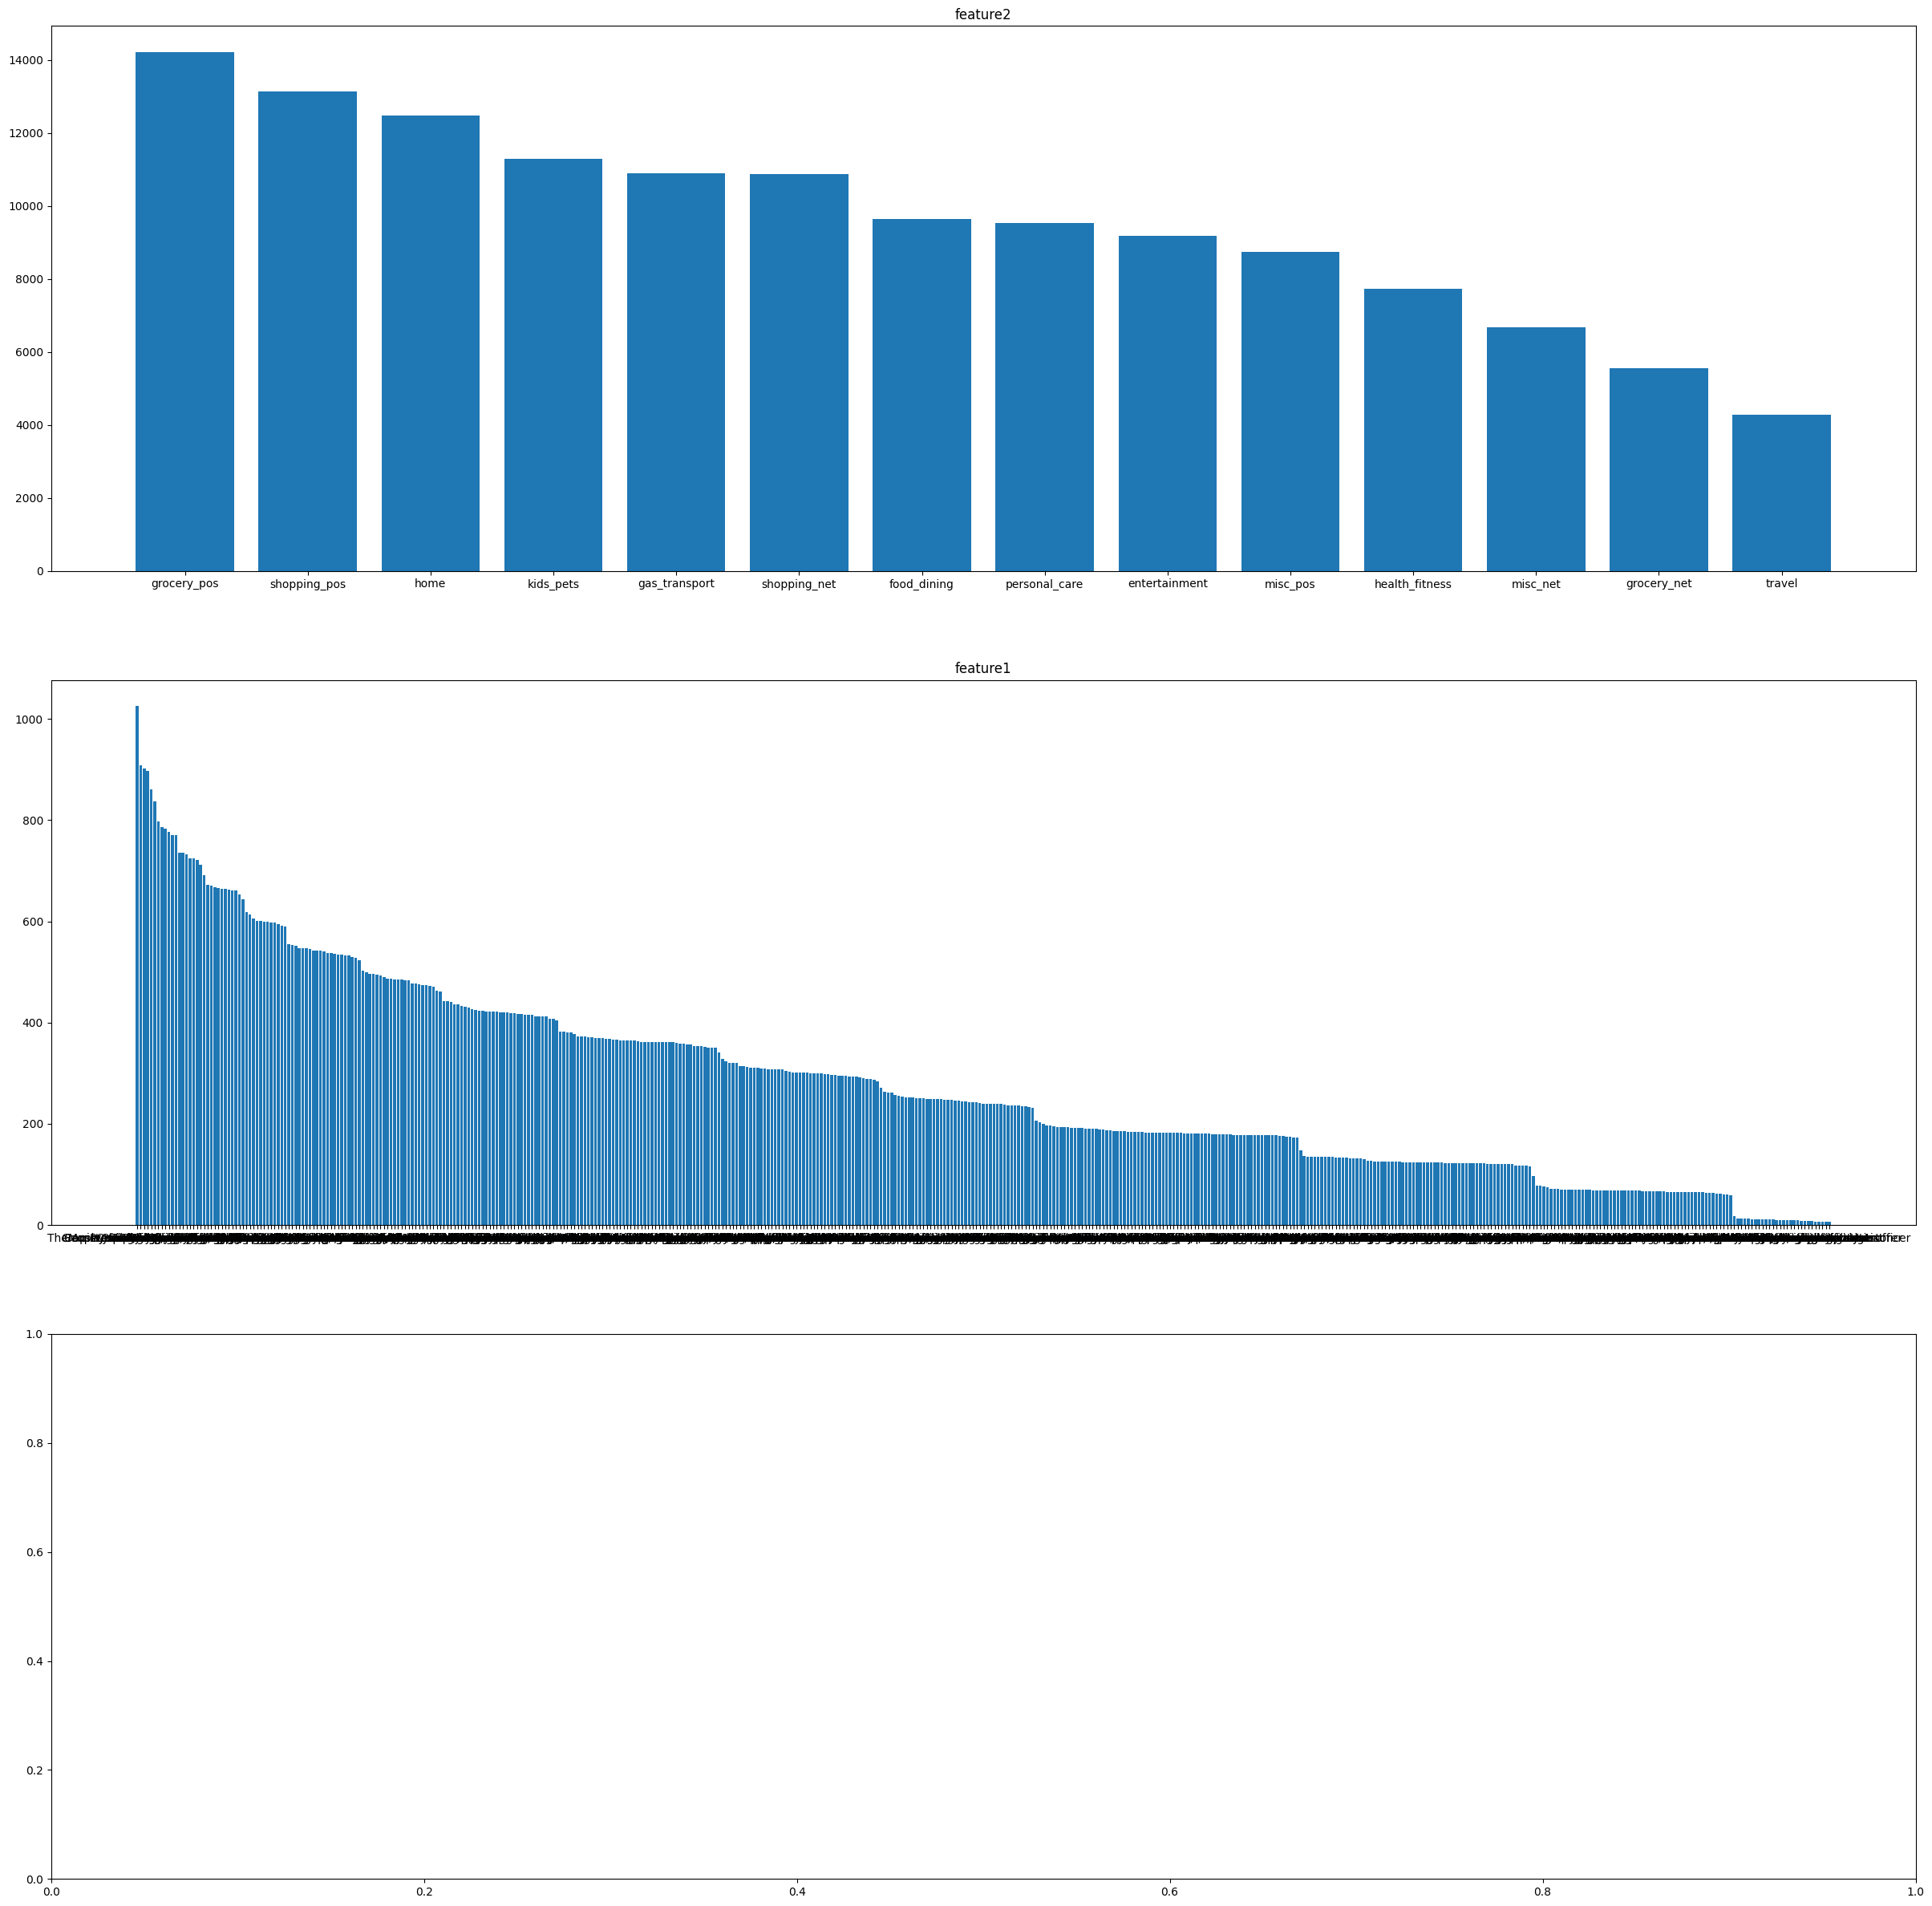

In [85]:
n_cat = len(features_config['category_columns'])
n_col = 3
n_row = max(n_cat // 3 + 1, 1)
# print(n_col, n_row)
fig, ax = plt.subplots(n_col, n_row, figsize=(30,30), squeeze=False)
# print(ax.shape)
for i, feature_name in enumerate(features_config['category_columns']):
    x = i % n_col
    y = i // n_col
    data = train_data[feature_name].value_counts().to_dict()
    # print(x, y)
    ax[x, y].bar(data.keys(), data.values())
    ax[x, y].set_title(feature_name)
plt.show()

In [86]:
X = train_data.drop('label', axis=1)
y = train_data.label

In [87]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectPercentile, chi2
from xgboost import XGBClassifier
from sklearn.decomposition import PCA

np.random.seed(0)

In [88]:
from sklearn.base import BaseEstimator, TransformerMixin
class DropColumnTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns = []):
        self.columns = columns
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Perform arbitary transformation
        X = X.drop(columns=self.columns)
        return X

In [89]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), 
           ("scaler", StandardScaler()),
           ('pca', PCA())
           ]
)
categorical_transformer = Pipeline(
    steps=[
        ("drop_column", DropColumnTransformer(['feature1'])),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        # ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, features_config['numeric_columns']),
        ("cat", categorical_transformer, features_config['category_columns']),
    ]
)

In [90]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", XGBClassifier())]
)

In [98]:
step_pca = X.shape[1]//3
param_grid = {
    'preprocessor__num__pca__n_components': np.arange(1, len(features_config['numeric_columns']), step_pca),
    'model__max_depth': [2, 3, 5, 7],
    'model__n_estimators': [10, 25, 50],
}
print(param_grid)
grid = GridSearchCV(clf, param_grid, cv=2, n_jobs=-1, scoring='roc_auc', verbose=1)


{'preprocessor__num__pca__n_components': array([ 1,  6, 11]), 'model__max_depth': [2, 3, 5, 7], 'model__n_estimators': [10, 25, 50]}


In [92]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# X_train.shape, y_train.shape

In [99]:
grid.fit(X, y)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


KeyboardInterrupt: 

In [ ]:
mean_score = grid.cv_results_["mean_test_score"][grid.best_index_]
std_score = grid.cv_results_["std_test_score"][grid.best_index_]

grid.best_params_, mean_score, std_score

print(f"Best parameters: {grid.best_params_}")
print(f"Mean CV score: {mean_score: .6f}")
print(f"Standard deviation of CV score: {std_score: .6f}")

Best parameters: {'model__max_depth': 5, 'model__n_estimators': 50, 'preprocessor__num__pca__n_components': 11}
Mean CV score:  0.992671
Standard deviation of CV score:  0.003819


In [ ]:
# y_pred = grid.predict(X_test)
# p = precision_score(y_test, y_pred)
# r = recall_score(y_test, y_pred)
# roc = roc_auc_score(y_test, y_pred)

In [ ]:
# p, r, roc

In [ ]:
import pickle
model_path = 'prob_1.ckpt'
pickle.dump(grid.best_estimator_, open(model_path, 'wb'))